## NN Tuned

In [1]:
import pandas as pd
def generate_features(df):
 features = ['seconds_in_bucket', 'imbalance_buy_sell_flag',
 'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
 'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap',
 'imb_s1', 'imb_s2'
 ]

 df['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
 df['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')

 prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

 for i,a in enumerate(prices):
 for j,b in enumerate(prices):
 if i>j:
 df[f'{a}_{b}_imb'] = df.eval(f'({a}-{b})/({a}+{b})')
 features.append(f'{a}_{b}_imb')

 for i,a in enumerate(prices):
 for j,b in enumerate(prices):
 for k,c in enumerate(prices):
 if i>j and j>k:
 max_ = df[[a,b,c]].max(axis=1)
 min_ = df[[a,b,c]].min(axis=1)
 mid_ = df[[a,b,c]].sum(axis=1)-min_-max_
 df[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)
 features.append(f'{a}_{b}_{c}_imb2')

 return df[features]
TRAINING = False
if TRAINING:
 df_train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
 df_ = generate_features(df_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GPU is available and being used


# Utils

In [2]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
import numpy as np
import joblib
import os
os.system('mkdir models')

model_path ='/kaggle/input/optiverbaselinezyz'
N_fold = 5
if TRAINING:
 X = df_.values
 Y = df_train['target'].values
 X = X[np.isfinite(Y)]
 Y = Y[np.isfinite(Y)]
 index = np.arange(len(X))
models = []
def train(model_dict, modelname='lgb'):
 if TRAINING:
 model = model_dict[modelname]
 model.fit(X[index%N_fold!=i], Y[index%N_fold!=i],
 eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])],
 verbose=10,
 early_stopping_rounds=100
 )
 models.append(model)
 joblib.dump(model, './models/{modelname}_{i}.model')
 else:
 models.append(joblib.load(f'{model_path}/{modelname}_{i}.model'))
 return
model_dict = {
 'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=500),
 'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=500),
 'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=3000),
}
for i in range(N_fold):
 train(model_dict, 'lgb')
# train(model_dict, 'xgb')
 train(model_dict, 'cbt')


In [3]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
 feat = generate_features(test)

 sample_prediction['target'] = np.mean([model.predict(feat) for model in models], 0)
 env.predict(sample_prediction)
 counter += 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [4]:
train_df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

# EDA

In [5]:
train_df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


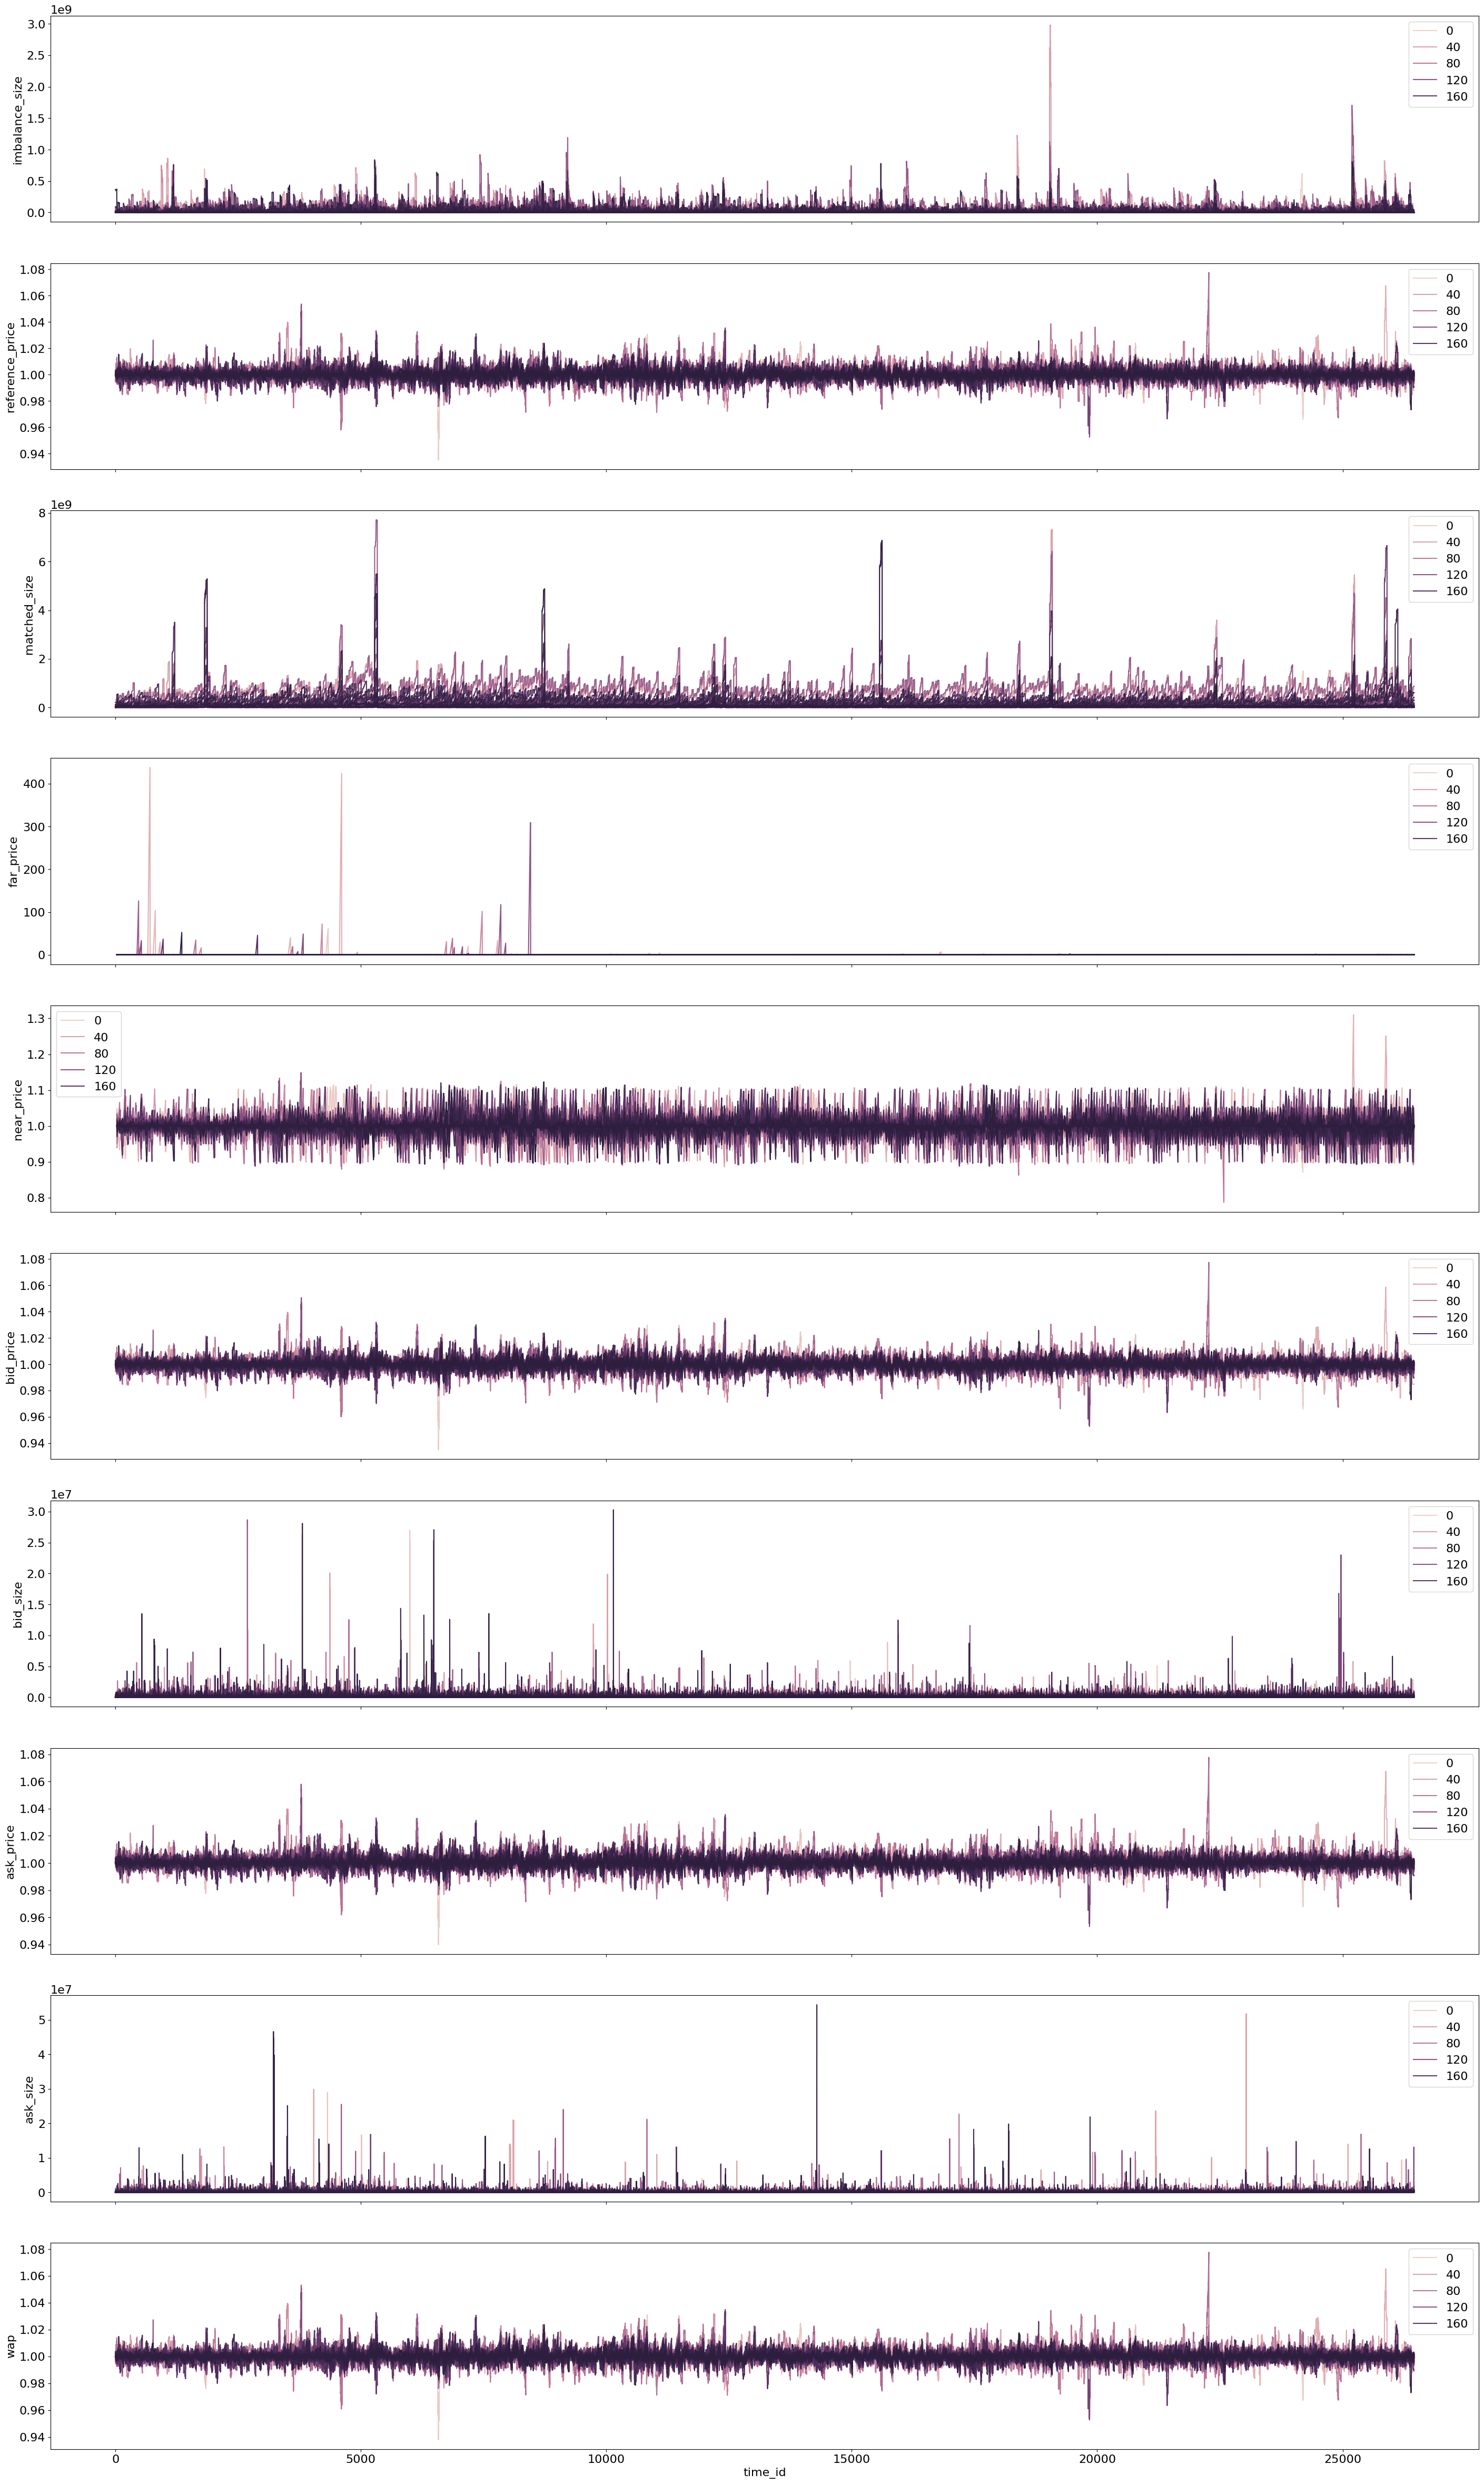

In [6]:
def plot_hist(df):
    COLS = list(df.drop(['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id', 'imbalance_buy_sell_flag', 'time_id'], axis=1).columns)
    fig, axes = plt.subplots(10, 1, sharex=True, figsize=(35,60))
    for col, ax in zip(COLS, axes.ravel()):
        sns.lineplot(data=df, x='time_id', y=df[col], hue='stock_id', ax=ax)
        ax.legend(loc='best')       
if not CFG.DEBUG:
    plot_hist(train_df)

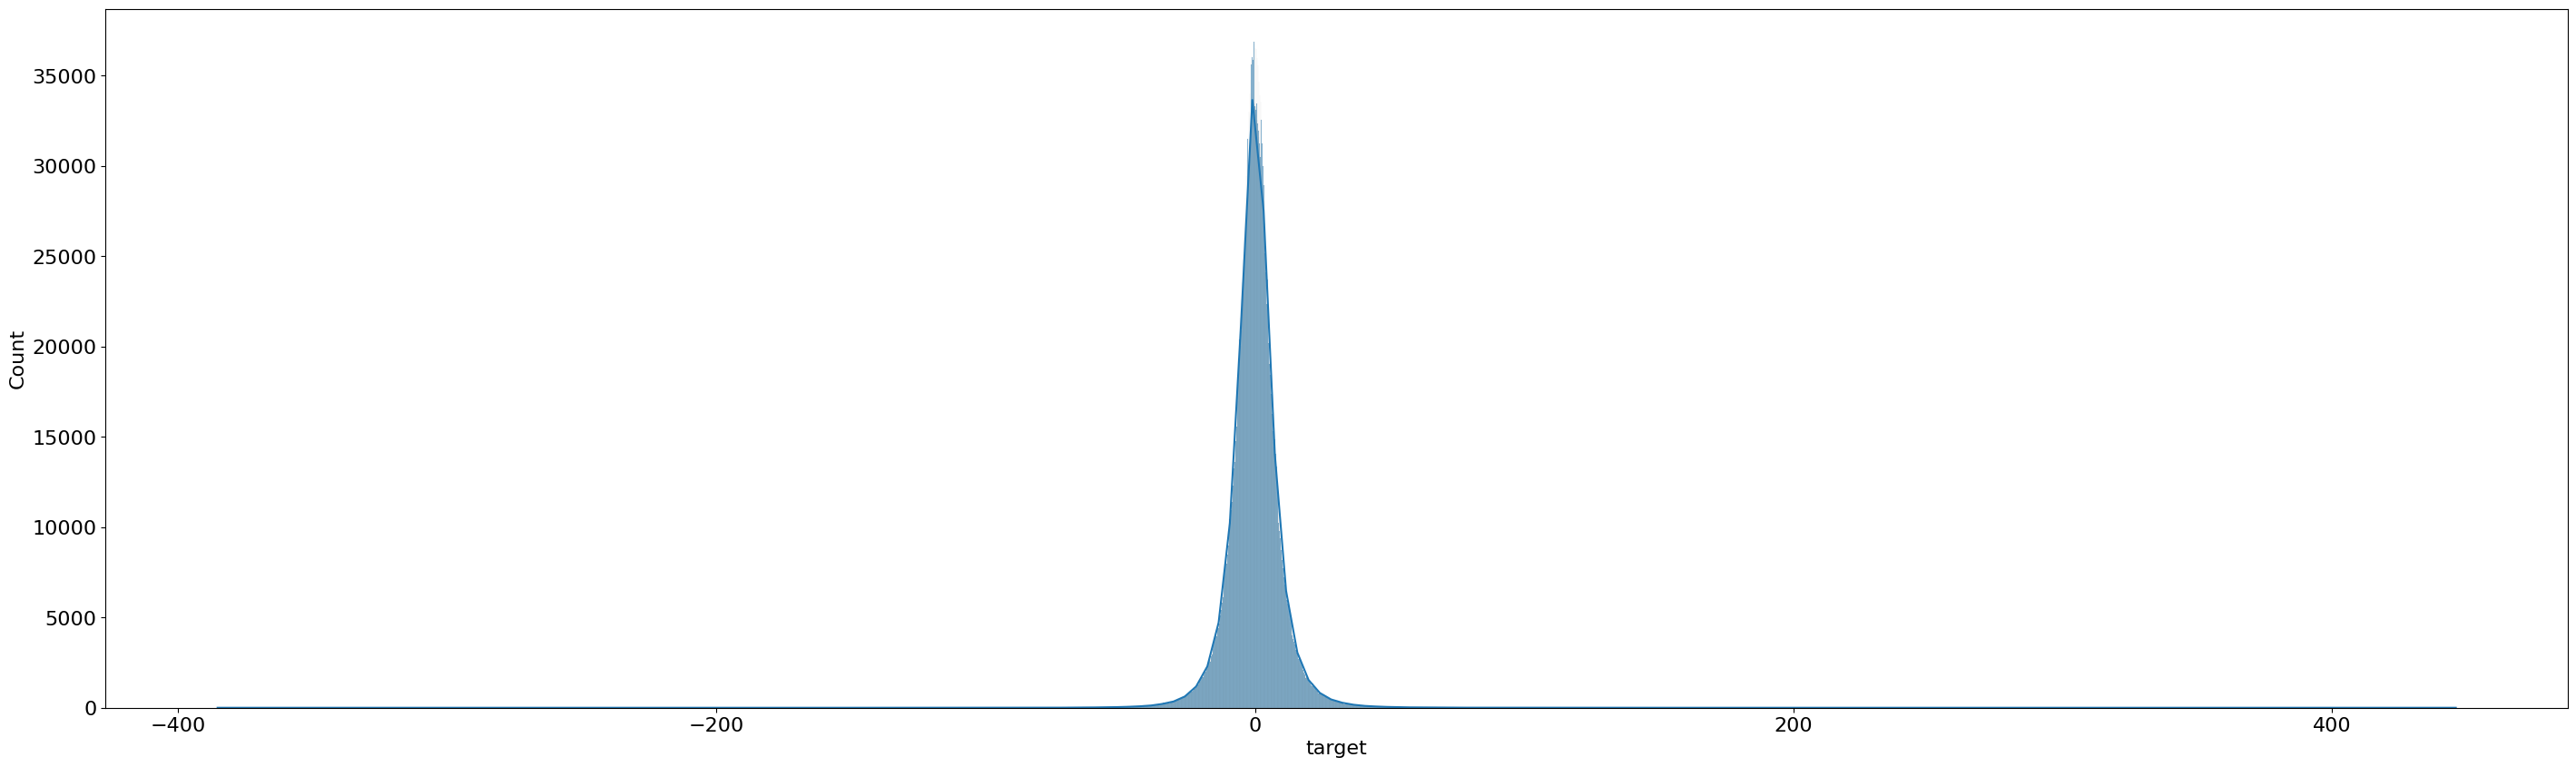

In [7]:
def plot_target(df):
    plt.figure(figsize=(35, 10))
    sns.histplot(data=df, x='target', kde=True) 
if not CFG.DEBUG:
    plot_target(train_df)

/opt/conda/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


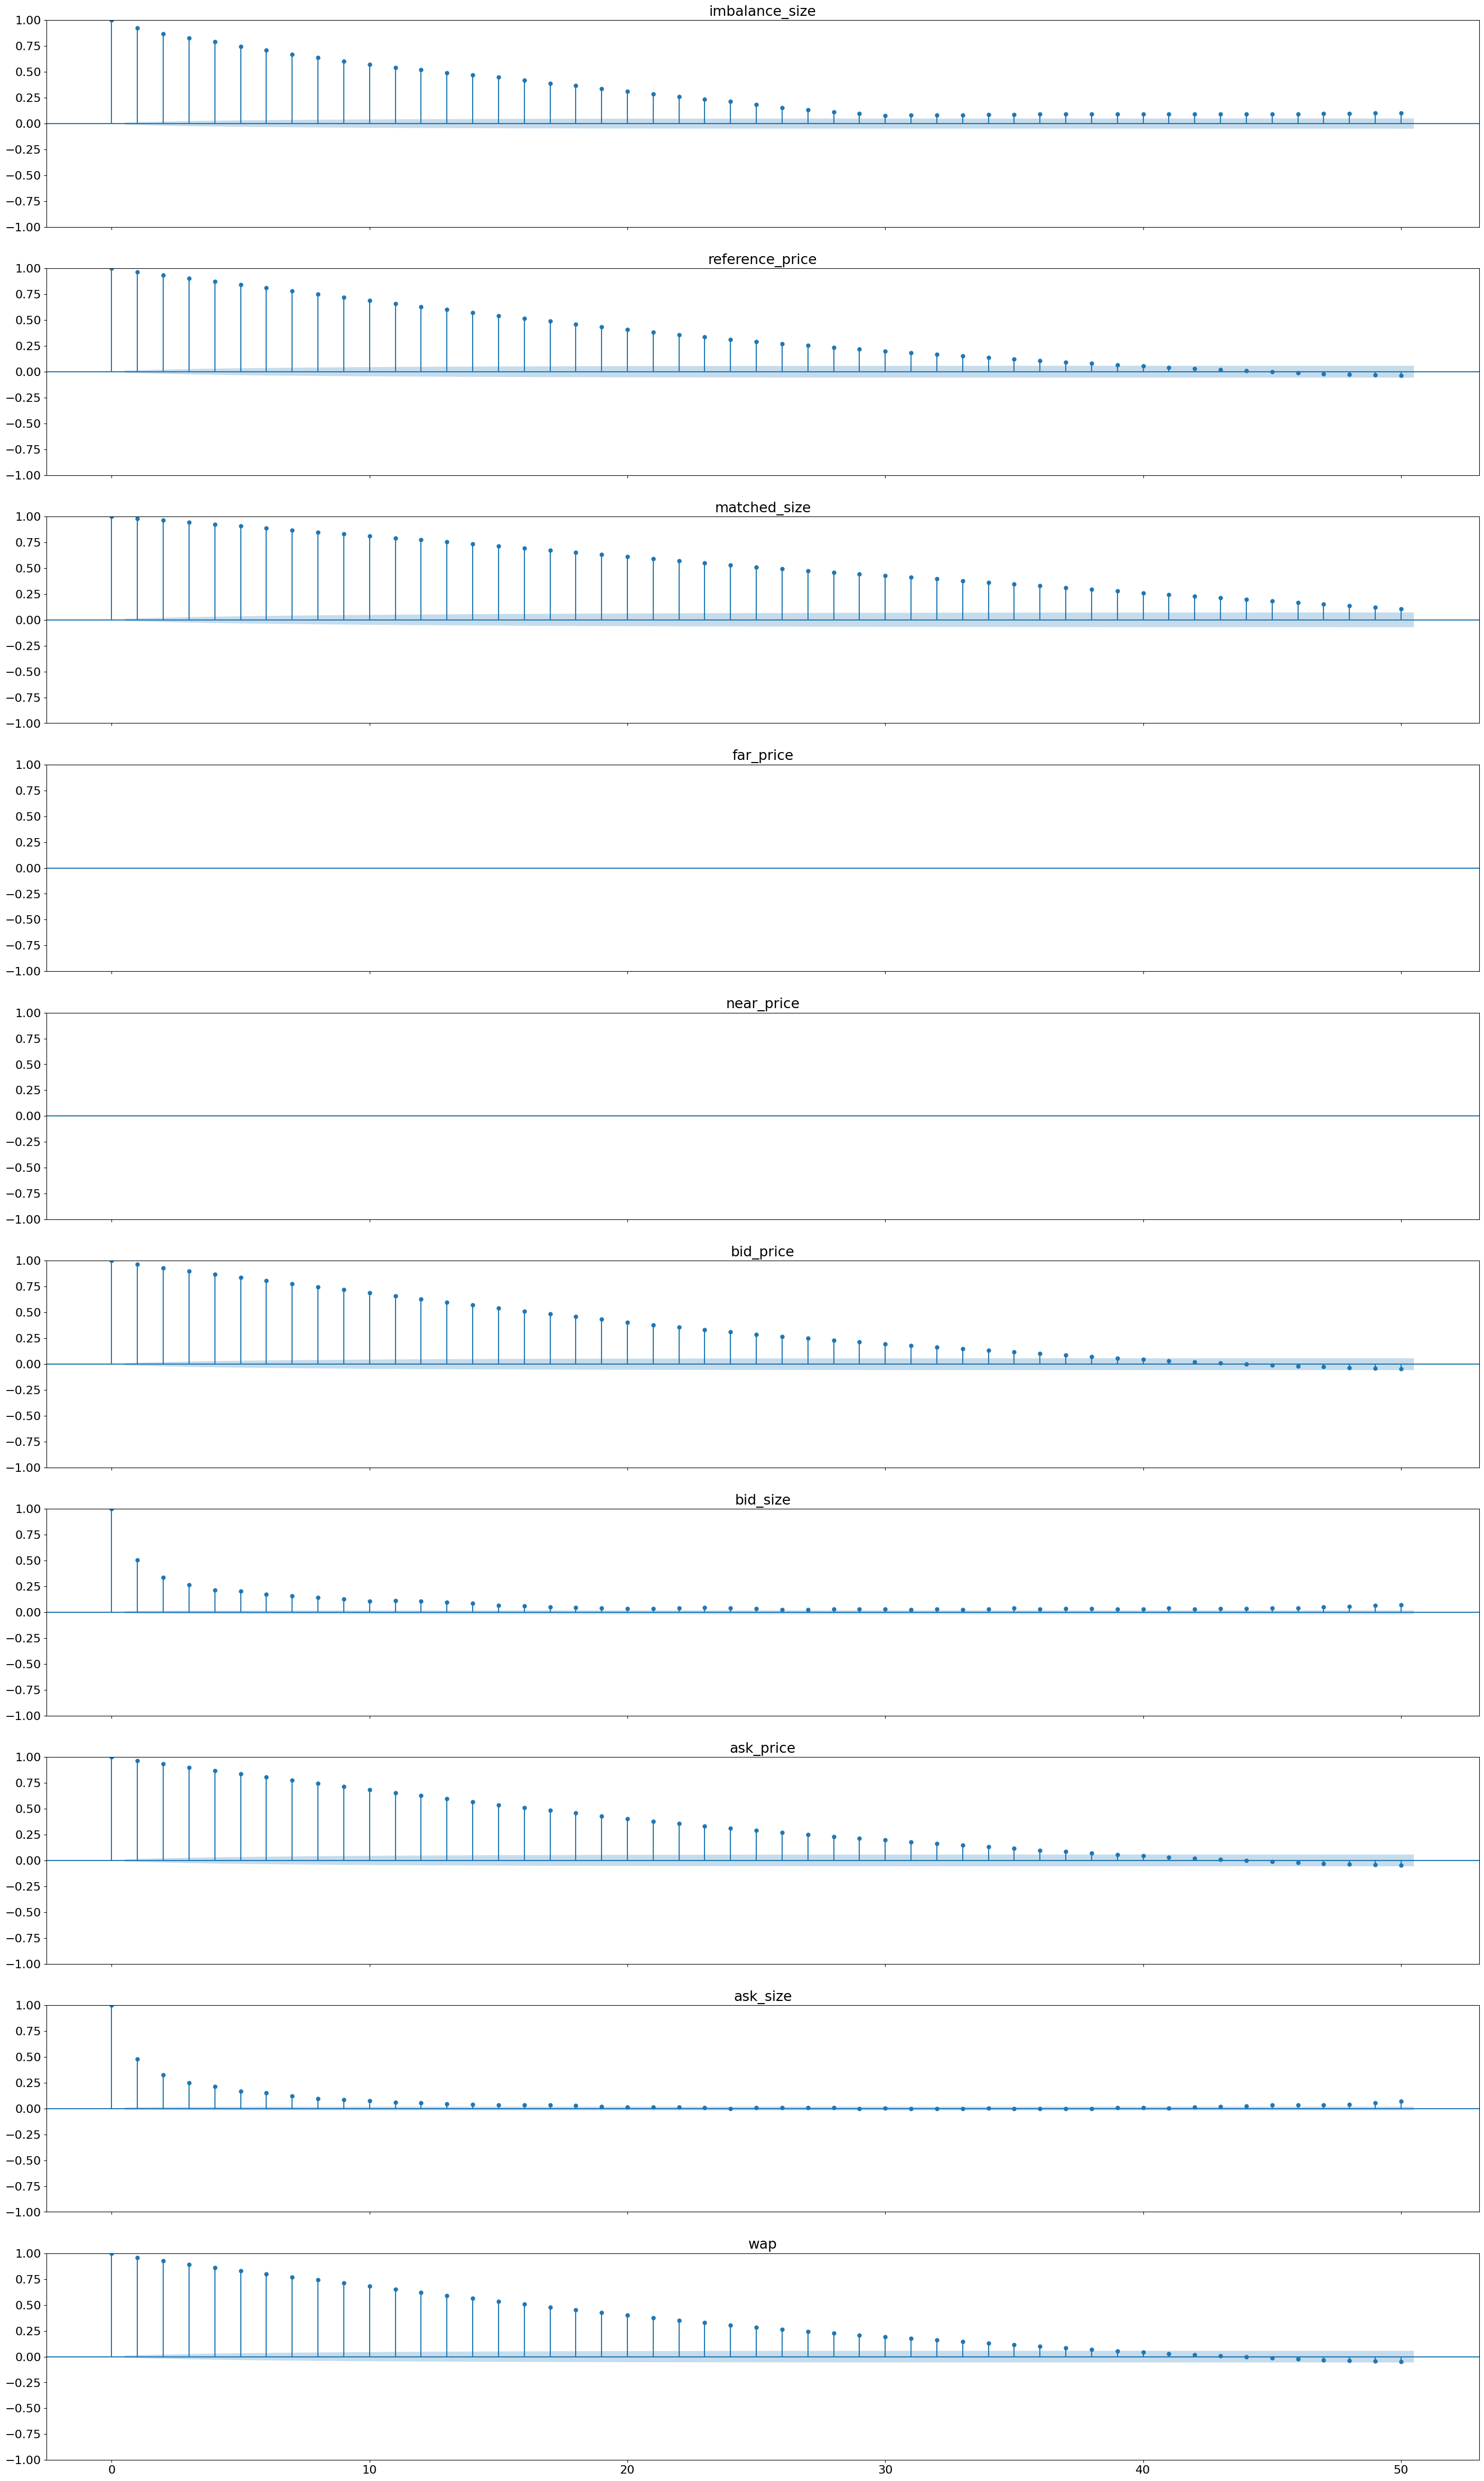

In [8]:
def plot_auto_corr(df):
    COLS = list(df.drop(['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id', 'imbalance_buy_sell_flag', 'time_id'], axis=1).columns)
    fig, axes = plt.subplots(10, 1, sharex=True, figsize=(35,60))
    for col, ax in zip(COLS, axes.ravel()):
        stock = df[df['stock_id']==1]
        plot_acf(stock[col][:500000], lags=50, ax=ax)
        ax.set_title(str(col))
if not CFG.DEBUG:
    plot_auto_corr(train_df)

# PreProcessing

In [9]:
train_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [10]:
def preprocess(df, mode='train'):
    df['log_return'] = np.log(df['wap'])
    df.drop(['imbalance_buy_sell_flag', 'far_price', 'near_price'], axis=1, inplace=True) 
    
    for i in range(1, 20):
        df[f'imbalance_size_lag_{i}'] = df.groupby('stock_id')['imbalance_size'].shift(i)
        df[f'reference_price_lag_{i}'] = df.groupby('stock_id')['reference_price'].shift(i)
        df[f'matched_size_lag_{i}'] = df.groupby('stock_id')['matched_size'].shift(i)
        df[f'bid_price_lag_{i}'] = df.groupby('stock_id')['bid_price'].shift(i)
        df[f'ask_price_lag_{i}'] = df.groupby('stock_id')['ask_price'].shift(i)
        df[f'wap_{i}'] = df.groupby('stock_id')['wap'].shift(i)
    
    df['bid_size_lag_1'] = df.groupby('stock_id')['bid_size'].shift(1)
    df['ask_size_lag_1'] = df.groupby('stock_id')['ask_size'].shift(1)
    
    df.fillna(0, inplace=True)
    # Standardize
    if mode == 'train':
        cols_to_norm = df.drop(['stock_id', 'time_id', 'date_id', 'row_id', 'target'], axis=1).columns
        df[cols_to_norm] = CFG.SCALER.fit_transform(df[cols_to_norm])
    elif mode == 'test':
        cols_to_norm = df.drop(['stock_id', 'date_id', 'row_id'], axis=1).columns
        df[cols_to_norm] = CFG.SCALER.transform(df[cols_to_norm])
    else:
        print('Wrong Mode.')
    return df
    
train_df = preprocess(train_df)

In [11]:
train_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,...,ask_price_lag_18,wap_18,imbalance_size_lag_19,reference_price_lag_19,matched_size_lag_19,bid_price_lag_19,ask_price_lag_19,wap_19,bid_size_lag_1,ask_size_lag_1
0,0,0,0.0,0.001067,0.927910,0.001735,0.927910,0.002003,0.927809,0.000156,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,0.0,0.000056,0.927988,0.000213,0.927988,0.000107,0.928397,0.000379,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0,0.0,0.000102,0.927677,0.000236,0.927531,0.001253,0.928061,0.000349,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0,0.0,0.003997,0.928243,0.002384,0.928084,0.000077,0.927983,0.008805,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0,0.0,0.000150,0.927650,0.002315,0.927522,0.000544,0.927800,0.000008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,1.0,0.000818,0.928379,0.003666,0.928379,0.001065,0.928188,0.005879,...,0.927971,0.928021,0.000177,0.928055,0.003503,0.928055,0.927863,0.927933,0.002260,0.002277
5237976,196,480,1.0,0.000117,0.928681,0.001191,0.928681,0.006772,0.928620,0.001717,...,0.928381,0.928408,0.000179,0.928681,0.001153,0.928681,0.928620,0.928704,0.006577,0.001840
5237977,197,480,1.0,0.000000,0.924176,0.001650,0.924176,0.000554,0.923965,0.003309,...,0.925356,0.925169,0.000127,0.925394,0.001606,0.925307,0.925269,0.925155,0.003281,0.001469
5237978,198,480,1.0,0.000336,0.927351,0.012286,0.927129,0.004148,0.927052,0.012313,...,0.927276,0.927320,0.000000,0.927129,0.012032,0.927129,0.927052,0.927070,0.004753,0.008232


# CV

In [12]:
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_val_group_size=np.inf,
                 max_test_group_size=np.inf,
                 val_group_gap=None,
                 test_group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.max_val_group_size = max_val_group_size
        self.max_test_group_size = max_test_group_size
        self.val_group_gap = val_group_gap
        self.test_group_gap = test_group_gap
        self.verbose = verbose
        
    def split(self, X, y=None, groups=None):
        return self.split_standard(X, y, groups)
        
    def split_standard(self, X, y=None, groups=None):
        """Generate indices to split data into training and validation set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/validation set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        val : ndarray
            The validation set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_splits = self.n_splits
        group_gap = self.val_group_gap
        max_val_group_size = self.max_val_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_val_size = min(n_groups // n_folds, max_val_group_size)
        group_val_starts = range(n_groups - n_splits * group_val_size,
                                  n_groups, group_val_size)
        for group_val_start in group_val_starts:
            train_array = []
            val_array = []

            group_st = max(0, group_val_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_val_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for val_group_idx in unique_groups[group_val_start:
                                                group_val_start +
                                                group_val_size]:
                val_array_tmp = group_dict[val_group_idx]
                val_array = np.sort(np.unique(
                                              np.concatenate((val_array,
                                                              val_array_tmp)),
                                     axis=None), axis=None)

            val_array  = val_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in val_array]

# Model

In [13]:
def global_average_pooling(x):
    return x.mean(dim=(-1))
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.batchnorm1d = nn.BatchNorm1d(200)
        self.conv1d1 = nn.Conv1d(200, 8, 3)
        self.conv1d2 = nn.Conv1d(8, 8, 3)
        self.conv1d3 = nn.Conv1d(8, 16, 3)
        self.conv1d4 = nn.Conv1d(16, 16, 3)
        self.conv1d5 = nn.Conv1d(16, 32, 3)
        self.conv1d6 = nn.Conv1d(32, 32, 3)
        self.conv1d7 = nn.Conv1d(32, 32, 3)
        
        self.pool1d1 = nn.AvgPool1d(2)
        self.pool1d2 = nn.AvgPool1d(2)
     
        self.linear1 = nn.Linear(32, 32)
        self.linear2 = nn.Linear(32, 200)

    def forward(self, inputs):
        x = self.batchnorm1d(inputs)
        x = self.conv1d1(x)
        x = self.conv1d2(x)
        x = self.pool1d1(x)
        
        x = self.conv1d3(x)
        x = self.conv1d4(x)
        x = self.pool1d2(x)
        
        x = self.conv1d5(x)
        x = self.conv1d6(x)
        x = self.conv1d7(x)

        out = global_average_pooling(x)

        out = self.linear1(out)
        out = nn.ReLU()(out)
        
        output = self.linear2(out)
        
        return output

In [14]:
def pad_df(df):
    missing_ids = list(set(np.arange(0, 200)) - set(df.index))
    for id in missing_ids:
        df.loc[id] = 0
    df.sort_index(inplace=True)
    return df
    
def get_dataset(df):
    X = []
    y = []
    for name, group in df.groupby('time_id'):
        group = group.set_index('stock_id')
        if len(group) < 200:
            group = pad_df(group)  
        features = torch.tensor(group.drop(['time_id', 'date_id', 'row_id', 'target'], axis=1).values, dtype=torch.float32)
        labels = group['target'].values 
        X.append(features)
        y.append(labels)
    X_ = torch.stack(X)
    y_ = torch.tensor(np.array(y), dtype=torch.float32)
    return TensorDataset(X_, y_)       

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def get_score(y_val, y_pred):
    all_scores = []
    for i in range(len(y_val)):
        score = mean_absolute_error(y_val[i], y_pred[i])
        all_scores.append(score)
    return np.mean(all_scores)
        
def train_fn(fold, train_dataloader, model, loss_fn, optimizer, epoch, device):
    losses = AverageMeter()
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        losses.update(loss.item(), labels.size(0))
        loss.backward()
        optimizer.step()
    return losses.avg

def valid_fn(valid_dataloader, model, loss_fn, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    for step, (input_ids, labels) in enumerate(valid_dataloader):
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            outputs = model(input_ids)   
            loss = loss_fn(outputs, labels)
        losses.update(loss.item(), batch_size)
        preds.append(outputs.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def train_loop(train, val, fold):
    print(f'----------------- Fold: {fold+1} -----------------') 
    
    train_ds = get_dataset(train)
    val_ds = get_dataset(val)
    _, y_val = val_ds[:]
    
    train_dataloader = DataLoader(
            train_ds,  
            batch_size = CFG.BATCH_SIZE 
    )

    val_dataloader = DataLoader(
            val_ds,  
            batch_size = CFG.BATCH_SIZE
    )
    
    model = CNN().to(device)
    optimizer_parameters = [
            {'params': [p for n, p in model.named_parameters()],
             'lr': CFG.LEARNING_RATE, 'weight_decay': CFG.WEIGHT_DECAY},
        ]

    
    optimizer = torch.optim.AdamW(optimizer_parameters)
    loss_fn = nn.MSELoss()
    min_score = np.inf        
    wait = 0
    patience=10
    
    for epoch in range(CFG.N_EPOCHS):
        avg_loss = train_fn(fold, train_dataloader, model, loss_fn, optimizer, epoch, device)

        avg_val_loss, y_pred = valid_fn(val_dataloader, model, loss_fn, device)
   
        score = get_score(y_val, y_pred)

        print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f} avg_val_loss: {avg_val_loss:.4f} MAE: {score:.4f}')
           
        wait += 1
        if round(score, 4) < round(min_score, 4):
            min_score = score
            wait = 0
            torch.save(model.state_dict(), f'model_fold_{fold+1}')
            print(f'﹂ saving model with score: {min_score:.4f}')
        if wait >= patience:
            print(f'Triggering Early Stopping on epoch {epoch+1}')
            return min_score
        
    gc.collect()

In [16]:
def train(df):
    Fold = PurgedGroupTimeSeriesSplit(n_splits=CFG.N_FOLDS,
                                      max_train_group_size=10000,
                                      max_val_group_size=200,
                                      val_group_gap=10)
    scores = np.empty([CFG.N_FOLDS])
    groups = df['time_id']
    for fold, (train_index, val_index) in enumerate(Fold.split(df, df[CFG.TARGET_COLS], groups=groups)):
        train = df.iloc[train_index].reset_index(drop=True)
        val = df.iloc[val_index].reset_index(drop=True)
        score = train_loop(train, val, fold)
        scores[fold] = score
    print(f'Average MAE across folds: {np.mean(scores)}')
         
train(train_df)

----------------- Fold: 1 -----------------
Epoch 1 - avg_train_loss: 86.5916 avg_val_loss: 62.4621 MAE: 5.5060
﹂ saving model with score: 5.5060
Epoch 2 - avg_train_loss: 86.5851 avg_val_loss: 62.4560 MAE: 5.5055
﹂ saving model with score: 5.5055
Epoch 3 - avg_train_loss: 86.5786 avg_val_loss: 62.4437 MAE: 5.5047
﹂ saving model with score: 5.5047
Epoch 4 - avg_train_loss: 86.5719 avg_val_loss: 62.4354 MAE: 5.5042
﹂ saving model with score: 5.5042
Epoch 5 - avg_train_loss: 86.5649 avg_val_loss: 62.4329 MAE: 5.5042
Epoch 6 - avg_train_loss: 86.5590 avg_val_loss: 62.4307 MAE: 5.5041
﹂ saving model with score: 5.5041
Epoch 7 - avg_train_loss: 86.5545 avg_val_loss: 62.4287 MAE: 5.5041
Epoch 8 - avg_train_loss: 86.5505 avg_val_loss: 62.4272 MAE: 5.5041
Epoch 9 - avg_train_loss: 86.5476 avg_val_loss: 62.4253 MAE: 5.5040
﹂ saving model with score: 5.5040
Epoch 10 - avg_train_loss: 86.5447 avg_val_loss: 62.4240 MAE: 5.5040
Epoch 11 - avg_train_loss: 86.5424 avg_val_loss: 62.4229 MAE: 5.5039
﹂ 

In [17]:
def get_models():
    models = []
    for i in range(CFG.N_FOLDS):   
        model = CNN()
        model.load_state_dict(torch.load(f'/kaggle/working/model_fold_{i+1}'))
        model.eval()
        models.append(model)
    return models

def inference(models, y_test):
    preds = []
    for i in range(len(models)):
        pred = models[i](y_test)[0]
        preds.append(pred.detach().numpy())
    return np.mean(preds, axis=0)

In [18]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()
history = pd.DataFrame()

models = get_models()

for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test): 
    preds = []
    history = pd.concat([history, test])
    history = history.reset_index(drop=True)
    history = preprocess(history, mode='test')
    y_test = history.iloc[-len(test):, :]
    y_test = torch.tensor(y_test.drop(['stock_id', 'date_id', 'row_id'], axis=1).values, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        preds = inference(models, y_test)
    sample_prediction['target'] = preds
    env.predict(sample_prediction)
    gc.collect()
        
gc.collect()

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- currently_scored
